This notebook explores the [Basic Pitch](https://basicpitch.spotify.com/) software, developed by researchers at Spotify, which transcribes raw audio files into digitized sheet music. The associated paper is located [here](https://https://arxiv.org/pdf/2203.09893.pdf).

# Setup
There are multiple parts to setup, including:  
1.   Installing packages 
2.  GitHub cloning  
3.   Mounting the training dataset via Google Drive; you'll need to add a shortcut to [this data folder](https://drive.google.com/drive/folders/1kX0rZxs3ulmfYYV9QJBsV8D8FdCKEZgU?usp=share_link) to your Google Drive account, located inside of "My Drive".  




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install dm-haiku
!pip install pretty_midi
!pip install optax

!pip install mir_eval
!pip install basic_pitch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 31 kB/s 
     |████████████████████████████████| 51 kB 2.7 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=319c67869d7cd29efd62b7d0674df52601c09ac436e81ca52f817295b503770e
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.7 MB/s 
     |████████████████████████████████| 85 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████

## Imports

To import our model/repository, you have two options: 

1) Uploading repository to Drive, and configuring path to have Python look for model in Drive subdirectory. 


2) Directly clone our Github repository, and configure path to look in home directory. 


We provide support for Option 1 below, as it enables easier integration with the training data, but it is simple to clone GitHub directly as in Option 2.

In [3]:
## STEP 1: Clone our GitHub repository and upload it to drive:
!git clone https://github.com/shalindb/bad-pitches.git badpitches

Cloning into 'badpitches'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 396 (delta 222), reused 290 (delta 123), pack-reused 0
Receiving objects: 100% (396/396), 9.34 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (222/222), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from typing import Union, List, Dict, Tuple

import numpy as np
# import tensorflow as tf
import random

import jax
from jax import value_and_grad
import jax.numpy as jnp
import optax
import haiku as hk

import librosa
import mir_eval
import pathlib
from tqdm import tqdm

import matplotlib.pyplot as plt
from pretty_midi import PrettyMIDI

from IPython.display import Audio

import sys
import os

### IMPORTANT: This is telling Python where to look for our build of the model.
### Change FOLDER_PATH as necessary to ensure Python can import our model properly. 
### if you cloned directly to your CoLab instead, change this to be "badpitches/v3".
FOLDER_PATH = "badpitches/v3"
sys.path.insert(0, FOLDER_PATH)

from loss import loss_dict
from constants import *
from new_model_in_jax import PosteriorgramModel
from cqt_and_hs import *

## Utility Functions

In [8]:
def audio_info(path, window_len=ANNOT_N_FRAMES, window_num=0):
  """
  Returns the onset, contour, and note matrices as a dictionary for the appropriate
  window of the MIDI file located at the given path.
  returns (batch, freq, time)
  """

  midi_fps = ANNOTATIONS_FPS

  pm = PrettyMIDI(path)

  start_frame = window_num * window_len
  end_frame = (window_num + 1) * window_len
  note_matrix = pm.get_piano_roll(fs=midi_fps)[21:109, start_frame:end_frame] / 127 #21 to 109 is piano bins

  onsets = np.array(pm.get_onsets() * midi_fps)
  logical_indices = np.logical_and(start_frame < onsets, onsets < end_frame)
  windowed_onsets = np.floor(onsets[logical_indices] - start_frame)

  onset_matrix = np.zeros_like(note_matrix, dtype=bool)
  
  for frame in windowed_onsets.astype(int):
    vec = note_matrix[: , frame]
    prev_vec = note_matrix[: , max(0, frame - 1)]
    onset_notes = np.argwhere(vec - prev_vec).ravel()
    for note in onset_notes:
      onset_matrix[note][frame] = True

  contour_array = [(row if i == 1 else np.zeros(row.shape)) for i in range(3) for row in note_matrix]

  return {
    "onset": jnp.array(onset_matrix),
    "contour": jnp.array(contour_array),
    "note": jnp.array(note_matrix)
  }

# Question 1: Familiarizing yourself with data
Before you start with training or tailoring the model, we want to help you familiarize yourself with the input and output data.

`basic-pitch` is a audio-to-MIDI converter: it takes in most audio formats (here, you will encounter them as `.wav` files), and outputs three things: contours (nuances or inflections, i.e. how a note is played), pitches of the notes, and onsets (when notes begin being played).

In the data folder, there are `.wav` files (the raw audio inputs) and `.midi` files (expected outputs). From these we can compare the model's outputs to what is expected. You do not need to worry about the signal preprocessing or postprocessing steps; we have taken care of that for you.

## Visualize / Audiate Predictions
Here we will choose a sample to listen to (via a `.wav` file), visualize the MIDI file that generated it, and compare it to the actual `basic-pitch` pre-trained model's output (since the model is computationally intensive to train, and we recognize not everyone may have the resources to run it). 

The plot you will see are the actual notes of the MIDI (digitized sheet music) file, including duration and pitch. The audio files (except for the raw input file) are the result of the MIDI playback.

<!-- The middle plot illustrates the "contours," or nuances of notes (because we're only working with a piano dataset here, there is little new information to be found). The last plot describes "onsets" of notes, or when notes are first played.  -->

In [9]:
data_path = "/content/drive/MyDrive/badpitches_data/test_new/"
val_files = os.listdir(data_path)
files = [va.split(".")[0] for va in val_files if va.split(".")[-1] == 'midi']

In [10]:
sample_index = 3 # Change as you desire! This reflects the audio file in the corresponding folder
duration = 30 # Number of seconds to generate

### Raw audio, expected audio and MIDI

In [11]:
assert 0 <= sample_index < len(files)
sample_name = files[sample_index]

midi_file = data_path + sample_name + ".midi"
wav_file = data_path + sample_name + ".wav"

def plot_mat(mat):
    plt.figure(figsize=(15,7))
    plt.matshow(mat, fignum=1, aspect='auto', origin='lower')
    _ = plt.axis('off')
    
mats = audio_info(midi_file, window_num=0, window_len=ANNOTATIONS_FPS * duration)
# print(mats["note"].shape)
plot_mat(mats['note'])

raw_audio, _ = librosa.load(wav_file, duration=duration)
raw = Audio(raw_audio, rate=22050)

pm = PrettyMIDI(midi_file)
expected_audio = pm.synthesize(fs=22050)[:22050 * duration]
expected = Audio(expected_audio, rate=22050)

print("raw audio\nexpected output audio")
display(raw, expected)

Output hidden; open in https://colab.research.google.com to view.

# HW Q2: Data Augmentation

We can explore several forms of data augmentation and invariance that are special to audio representations including noise and pitch shift. 

Our model should be robust to noise in our audio, especially since it is easy to pick up background noise or other sounds that we want to exclude. As audio inputs are one-dimensional matrix (ie, is a sequence), it is fairly simple to add noise to the dataset uniformly and see the influence on predicting notes, pitches, and onsets. 

## HW Q2.1
We first empirically generate these audio samples, augmented as aforementioned; complete the code block and then listen to the resulting samples. 

In [13]:
def data_aug(audio_wave, aug_type, aug_factor=None, mixup_wave=None):
  # Adds random noise drawn from a Gaussian with mean 0 and standard deviation equal to aug_factor.
  if aug_type == 'noise':
    if aug_factor is None:
      print("Please specify how much you would like to noise by.")
      return
    out = audio_wave + np.random.normal(0, aug_factor, audio_wave.shape)
    return out

  # Combines the input wave together with some unrelated wave.
  # Weights the input wave by (1 - aug_factor), the unrelated wave by aug_factor, and combines them together.
  elif aug_type == 'mixup':
    if mixup_wave is None:
      print("Please specify which wave you would like to mix the input with.")
      return
    if aug_factor is None:
      print("Please specify how much you would like to mixup by.")
      return
    out = (1 - aug_factor) * audio_wave + aug_factor * mixup_wave
    return out

  # Pitch shifts up by aug_factor semitones.
  elif aug_type == 'pitch_shift':
    if aug_factor is None:
      print("Please specify how much you would like to pitch shift by.")
      return
    return librosa.effects.pitch_shift(audio_wave, sr=22050, n_steps=aug_factor)
  
  else:
    print(f'Invalid Input to aug_type: {aug_type}')

In [14]:
noise_factor = 0.02
shift_amt = 5
mixup_factor = 0.5

noised_audio = data_aug(raw_audio, "noise", noise_factor)
shifted_audio = data_aug(raw_audio, "pitch_shift", shift_amt)

# Mixes the original and shifted audio together. Can you hear it?
mixup_audio = data_aug(raw_audio, "mixup", mixup_factor, shifted_audio)

noised = Audio(noised_audio, rate=22050)
shifted = Audio(shifted_audio, rate=22050)
mixup = Audio(mixup_audio, rate=22050)

print("raw\nnoised\nshifted\nmixup")
display(raw, noised, shifted, mixup)

Output hidden; open in https://colab.research.google.com to view.

#### Sanity checks

In [15]:
np.random.seed(42) #Sets the random seed to 42
test_array = np.random.rand(182)
test_factor = np.random.random()

noised_output = data_aug(test_array, "noise", test_factor)
expected_output = np.array([ 0.04466027,  1.46495658,  1.69724519,  1.08546174,  1.41719581,
        2.50394208, -0.24197111,  0.67581251, -0.73048212,  1.80913047,
        1.22212844,  0.16806534,  1.40357119,  1.33775671,  0.39107229,
        0.96699121,  0.46590921, -0.60046152,  1.40226986,  1.51654589,
        1.29104134, -0.74312367, -0.40246617, -0.67893776,  1.16806314,
        1.95804766,  0.5921935 ,  1.38394169, -0.20988761,  0.18132794,
       -0.65916617, -0.54313661,  0.87755542,  0.72733402,  2.08393982,
        1.30584553,  2.83311649,  0.18437641, -0.61626095,  0.40822314,
       -0.76845617,  1.39876902,  0.07320722,  0.78238603,  0.14399555,
        1.34711071, -0.10667786,  1.23860101,  1.51354327, -0.1315218 ,
        0.11327523,  0.30079707,  1.59613242,  0.98034197,  1.18052625,
        2.55205127,  0.30205394, -0.55203592,  1.02302006,  0.37282339,
        1.19542361,  1.25725602, -0.05805116,  1.63468416,  1.11789501,
       -0.01573044,  0.42244638,  1.04003511,  0.09668024,  1.79314024,
        2.10135899,  0.20547184,  1.23617959,  1.72924608,  0.92166012,
        0.89192054, -0.2944995 , -1.3137063 ,  0.51106126, -0.67560295,
        0.82645214,  0.1288989 , -1.32291328,  0.39395558, -0.07233259,
        0.39934256, -0.09625644,  0.3279541 ,  2.3300863 ,  0.59108521,
        0.62778398, -0.46192226,  2.96991135,  2.26587014,  2.03172728,
        1.26015021,  0.53673572,  0.83632404,  0.9945163 , -0.47334301,
       -0.37959597, -0.90702563, -0.39934019,  2.0447658 ,  0.59849032,
       -0.04461878,  0.70422007, -0.73526516,  1.10298658,  1.24801825,
        0.6386349 ,  1.68821501, -0.29721521,  2.51299261, -0.04230816,
       -0.31207302,  0.58415725,  1.91760176,  0.87458097, -0.32301931,
       -0.38998489,  0.79888889, -1.52672476, -1.0922281 ,  1.65479997,
        1.65072139,  0.69927287,  0.43013334,  0.06105494,  2.68192508,
        0.79188927,  1.0633369 , -0.06734581,  0.39392588,  1.54133692,
        0.43980201, -1.23570177,  1.88712683, -0.20518058,  2.92410403,
        1.59757173,  0.31741004,  0.90349151,  0.200551  , -0.16496078,
        0.22885173,  1.42790937,  0.07313133, -0.52389998, -0.05007161,
        1.78858447,  1.58272583,  0.47964683,  1.02699023,  0.40337009,
        1.0527847 ,  1.18232324,  0.10496882, -1.41541099, -0.40043704,
       -0.25102436,  1.70674185,  2.06944924,  0.12935531, -0.28690695,
        1.07722367,  0.33201186,  1.04734732, -0.44301355,  1.46855941,
        0.45635472,  0.80625279,  0.26146367, -0.34042897,  2.41348071,
        1.15937511, -0.96615493, -0.02639327,  2.05091453, -0.96902335,
        1.05370768,  0.73029604])

assert np.linalg.norm(noised_output - expected_output) < 1e-6, f"Your error was {np.linalg.norm(noised_output - expected_output)} > 1e-6"

from scipy.signal import sawtooth
mix_wave = sawtooth(np.linspace(0, np.random.random(), test_array.shape[0]))
mixup_output = data_aug(test_array, "mixup", np.random.random(), mix_wave)

expected_mixup = np.array([ 0.24917367,  0.77292391,  0.57427883,  0.45323103,  0.05108929,
        0.05119403, -0.03766016,  0.69685606,  0.45609677,  0.5534258 ,
       -0.07123252,  0.79163522,  0.66683251,  0.10341286,  0.07580845,
        0.07737058,  0.18731382,  0.38784243,  0.30362263,  0.17586755,
        0.46737512,  0.03822476,  0.17707952,  0.2446543 ,  0.32630717,
        0.62552332,  0.09354917,  0.37954662,  0.4507229 , -0.04531934,
        0.46472652,  0.0676914 , -0.02803474,  0.7753148 ,  0.79066057,
        0.6478933 ,  0.19018451,  0.00224385,  0.53543348,  0.31374123,
        0.02476759,  0.36400039, -0.05463463,  0.74062477,  0.14954426,
        0.51658945,  0.19790102,  0.38738119,  0.41172017,  0.08299445,
        0.7962791 ,  0.61968914,  0.76919071,  0.7287201 ,  0.45900096,
        0.75355344, -0.00369214,  0.0941211 , -0.04275799,  0.21192459,
        0.26962057,  0.16312002,  0.66979792,  0.24098823,  0.1722112 ,
        0.41022518,  0.04522401,  0.64631131, -0.01484259,  0.81440972,
        0.61947088,  0.0983778 , -0.07706868,  0.65912587,  0.5605538 ,
        0.58081007,  0.61934524, -0.01416256,  0.24444423,  0.02410051,
        0.70330919,  0.48550225,  0.21989748, -0.02293253,  0.20205151,
        0.21508395,  0.58274762,  0.49922097,  0.72623281,  0.34921198,
        0.02887911,  0.56851175,  0.6118427 ,  0.43065784,  0.62134947,
        0.36958428,  0.39600891,  0.30962582, -0.05569344,  0.01938353,
       -0.04997824,  0.49995166,  0.20739721,  0.38402501,  0.74675659,
        0.14864763,  0.29517252,  0.60898594,  0.13040271, -0.00744215,
        0.18604999,  0.06936921,  0.76788249,  0.65752046,  0.49886571,
        0.71533696,  0.65385783,  0.09316593,  0.73489102,  0.41401644,
        0.65778884,  0.73848111,  0.21324508,  0.02438663,  0.13164485,
        0.31277837,  0.66815889,  0.70710542, -0.06867657,  0.38929606,
        0.30459925,  0.12723555,  0.0344449 ,  0.23246124,  0.78267587,
        0.21961679,  0.39749234,  0.56504458,  0.25673626,  0.80954817,
        0.80119143,  0.15547006,  0.37867491,  0.20034153,  0.18589311,
       -0.03931891,  0.48125346,  0.38424339, -0.02567801,  0.18089727,
        0.75321821,  0.14563076,  0.0597246 ,  0.37298336,  0.82405145,
        0.14840333,  0.53938432,  0.62083354,  0.14476849,  0.59073016,
        0.26329731,  0.50382057,  0.50505948,  0.41634696,  0.01161964,
        0.68880931,  0.22134112,  0.09945169, -0.03287234,  0.46719801,
        0.54609112, -0.05447367,  0.39596511,  0.1365427 ,  0.51716047,
        0.08942117,  0.55900468,  0.28267405,  0.78263248,  0.05644283,
        0.2415503 ,  0.03484198])

assert np.linalg.norm(mixup_output - expected_mixup) < 1e-6, f"Your error was {np.linalg.norm(mixup_output - expected_mixup)} > 1e-6"
np.random.seed() # Resets the seed for random behavior again

## HW Q2.2
Recall that we have three forms of output that our model can produce: note contours (inflections/nuances within notes, i.e., how a note is played), pitches of generated notes, and note onsets (when notes begin). Based on your intuition and the samples you listened to above, what invariances (and variances) should we expect to see in our outputs from 1) a model given a noisy audio sample and 2) a model given an audio that has been pitch-shifted? Answer this question in terms of effects on the three outputs. 

ANSWER: The noisy audio should have the same expected output as the original unmodified audio because background noise shouldn't affect the transcription. The pitch-shifted audio should have only the note pitches affected (pitch shifted upwards by the same amount as the input), but the contours and onsets should remain the same, because the nuances and timings of notes do not change.

## HW Q2.3

Recall that masking is the process of hiding certain inputs and restoring the original, unmasked input. Why would this augmentation not be as ideal in this context?

ANSWER: We must consider invariances that we want our augmentations to capture. One issue with masking in this context, for example, is that a note with the center of it masked, or muted, will come across as two notes, changing the expected output significantly.

# HW Q3: Training the Model and Validating Paper Results

Below is a visual of the architecture:

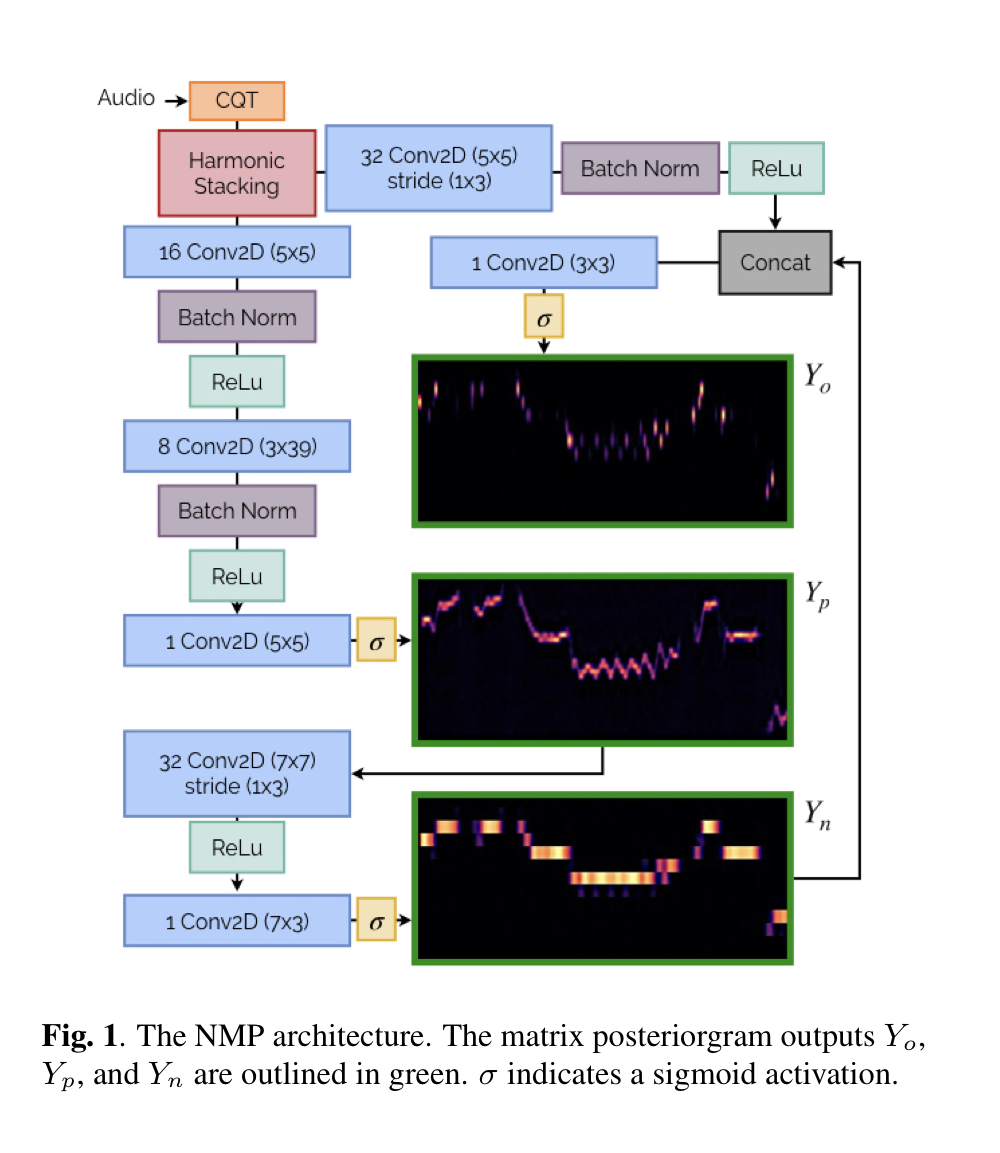
After the audio is windowed (reshaped so that the maximum “time window” is 2 seconds; fragments of a sample are cut up and stacked) frequency-transformed and stacked, there are two main branches that output is taken down to generate the desired outputs. Notice that in this branched architecture, the pitch output generated is passed through two additional convolution layers to produce the note output; and that output is concatenated with a differently convolved output to produce the onset output. 

## HW Q3.1: Completing Utility Functions


Before completing the training loop, we want to define some utility functions necessary for programming the loop. 

We have defined the specific functions in an instance of `loss_dict()`, initialized within the `loss_wrapper` function, with three keys (eponymously named `”contour”`, `”note”`, `”onset”`) to store each of the respective output’s loss functions. The loss that is returned should be a sum of the three outputs’ losses, which in turn are sums of the respective loss function calls. Complete the implementation of `loss_wrapper` to fulfill its desired functionality.  

## Training loop

At the top of the next cell, we have defined the various hyperparameters that you can use to tune the model. Test out various combinations of hyper parameters until you find a setting that lets you pass the accuracy threshold. 

In [18]:
rng = jax.random.PRNGKey(0)

#CHANGE PARAMETERS HERE; you are also welcome to adjust the choice of optimizer. 
epochs = 10
learning_rate = 0.01
adam_b1 = 0.9
adam_b2 = 0.999
eps = 1e-16
optimizer = optax.adam(learning_rate=learning_rate, 
                       b1=adam_b1, b2=adam_b2, eps=eps,)


def update_weights(weights,gradients):
    return optimizer.update(gradients, weights)

def loss_wrapper(params, state, x, y):
    out, new_state = model.apply(params, state, rng=rng, audio_tensor=x, is_training=True)
    loss_fns = loss_dict()
    contour_mat = jnp.expand_dims(jnp.transpose(y["contour"], (0,2,1)), -1)
    note_mat = jnp.expand_dims(jnp.transpose(y["note"], (0,2,1)), -1)
    onset_mat = jnp.expand_dims(jnp.transpose(y["onset"], (0,2,1)), -1)
    loss_yp = jnp.sum(loss_fns["contour"](contour_mat, out[0]))
    loss_yn = jnp.sum(loss_fns["note"](note_mat, out[1]))
    loss_yo = jnp.sum(loss_fns["onset"](onset_mat, out[2]))
    loss = loss_yp + loss_yn + loss_yo
    return loss, (loss, new_state)

def step(params, opt_state, state, x, y):
    # loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
    grads, (loss, state) = jax.grad(loss_wrapper, has_aux=True)(params, state, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, state, loss

def model_fn(audio_tensor, is_training):
    """returns (batch, time, freq, ch)"""
    bn = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, name="bn")
    normed = bn(audio_tensor, is_training)
    hs = harmonic_stacking(jnp.transpose(normed, axes=(0,2,1,3)))
    pgram = PosteriorgramModel()(hs, is_training)
    
    return pgram

In [19]:
### IMPORTANT: Change this path as necessary to ensure that CoLab can locate our data.
### You do not have to manually re-import the data to Drive; simply add a shortcut to the folder within your own Drive, 
### and that should be sufficient to help CoLab locate the data. 

data_path = "/content/drive/MyDrive/badpitches_data/test_new/"
val_files = os.listdir(data_path)
files = [va.split(".")[0] for va in val_files if va.split(".")[-1] == 'midi']

In [21]:
batched_inputs = np.zeros((BATCH_SIZE, 264, 173, 1))
batched_outputs = {
    'note': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES)),
    'contour': np.zeros((BATCH_SIZE, N_FREQ_BINS_CONTOURS, ANNOT_N_FRAMES)),
    'onset': np.zeros((BATCH_SIZE, N_FREQ_BINS_NOTES, ANNOT_N_FRAMES))
}

model = hk.transform_with_state(model_fn)
for i in range(BATCH_SIZE):
      rand_file_name = files[random.randint(0, len(files) - 1)]
      midi_file = data_path + rand_file_name + ".midi"
      wav_file = data_path + rand_file_name + ".wav"
      audio, window_num = load_cqt_window(wav_file) # if you get a transport endpoint error here just rerun this cell
      batched_inputs[i,:,:,:] = audio
params, state = model.init(rng, batched_inputs, True) # pass in augmented data here to train
opt_state = optimizer.init(params)
NUM_EPOCHS = 5
for _ in tqdm(range(1, NUM_EPOCHS+1)):
    for i in range(BATCH_SIZE):
        rand_file_name = files[random.randint(0, len(files) - 1)]
        midi_file = data_path + rand_file_name + ".midi"
        wav_file = data_path + rand_file_name + ".wav"
        audio, window_num = load_cqt_window(wav_file)
        matrices = audio_info(midi_file, window_num=window_num)
        batched_inputs[i,:,:,:] = audio
        batched_outputs['note'][i,:,:] = matrices['note']
        batched_outputs['contour'][i,:,:] = matrices['contour']
        batched_outputs['onset'][i,:,:] = matrices['onset']
    params, opt_state, state, loss = step(params, opt_state, state, batched_inputs, batched_outputs)
    print(loss)

/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
 20%|██        | 1/5 [00:23<01:33, 23.32s/it]

611794.0


 40%|████      | 2/5 [00:40<00:58, 19.52s/it]

563413.6


 60%|██████    | 3/5 [00:55<00:34, 17.44s/it]

539966.4


 80%|████████  | 4/5 [01:10<00:16, 16.43s/it]

523147.53


100%|██████████| 5/5 [01:24<00:00, 16.86s/it]

511756.75


## Benchmarking the Model with Fno (Computing F-Score)

Rather than computing the accuracy on the three different outputs, the paper instead uses a more useful metric, Fno, to compute a audio-informed metric that incorporates onset in addition to the notes themselves. 

**You must achieve an accuracy of greater than 25% to pass this block.**

In [26]:
# calculation:

from note_creation import model_output_to_notes
data_path = "/content/drive/MyDrive/badpitches_data/test_new/"
test_files = os.listdir(data_path)
test_files = [va.split(".")[0] for va in test_files if va.split(".")[-1] == 'midi']


FILE_COUNT = 20 # Number of files to benchmark on 

f_score = 0
for i in tqdm(range(FILE_COUNT)):
    test_file = test_files[i]
    midi_file = data_path + test_file + ".midi"
    
    wav_file = data_path + test_file + ".wav"
    audio, window_num = load_cqt_window(wav_file)

    output, _ = model.apply(params, state, rng, audio, is_training=False)
    np_mats = {
    'note': np.asarray(output[1]).reshape(-1, 88),
    'onset': np.asarray(output[2]).reshape(-1, 88),
    'contour': np.asarray(output[0]).reshape(-1, 264)
    }
    _, pred_note_events = model_output_to_notes(np_mats, 0.15, 0.05, include_pitch_bends=False, min_note_len=1)
    # print(audio_info(midi_file, window_num = window_num))

    true_labels = audio_info(midi_file, window_num = window_num)
    np_mats_true_labels = {
      'note': np.asarray(true_labels['note']),
      'onset': np.asarray(true_labels['onset']),
      'contour': np.asarray(true_labels['contour'])
      }

    _, actual_note_events = model_output_to_notes(np_mats_true_labels, 0.15, 0.05, include_pitch_bends=False, min_note_len=1)
    actual_note_events = list(map(lambda x: x[0], actual_note_events))
    actual_note_events.sort()
    pred_note_events =  list(map(lambda x: x[0], pred_note_events))
    pred_note_events.sort()

    f_score += mir_eval.beat.f_measure(np.array(actual_note_events), np.array(pred_note_events))
print()

computed_score = f_score / FILE_COUNT
print(computed_score)




100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


0.13558973198019045


In [27]:
# this largely depends on initial parameters and 
# how long the model has trained but we were able to get 28% acc after a few tries
assert computed_score >= 0.25

AssertionError: ignored

## HW Q3.2: Visualizing Predictions, Comparing Against Public Model:

In [28]:
sample_index = 3 # Change as you desire! This reflects the audio file in the corresponding folder
duration = 30 # Number of seconds to generate

### Raw audio, expected audio and MIDI

In [29]:
assert 0 <= sample_index < len(files)
sample_name = files[sample_index]

midi_file = data_path + sample_name + ".midi"
wav_file = data_path + sample_name + ".wav"

def plot_mat(mat):
    plt.figure(figsize=(15,7))
    plt.matshow(mat, fignum=1, aspect='auto', origin='lower')
    _ = plt.axis('off')
    
mats = audio_info(midi_file, window_num=0, window_len=ANNOTATIONS_FPS * duration)
# print(mats["note"].shape)
plot_mat(mats['note'])

raw_audio, _ = librosa.load(wav_file, duration=duration)
raw = Audio(raw_audio, rate=22050)

pm = PrettyMIDI(midi_file)
expected_audio = pm.synthesize(fs=22050)[:22050 * duration]
expected = Audio(expected_audio, rate=22050)

print("raw audio\nexpected output audio")
display(raw, expected)

Output hidden; open in https://colab.research.google.com to view.

### Model's predicted audio and MIDI

In [30]:
preprocessed_input = cqt_windowed(raw_audio)
output, _ = model.apply(params, state, rng, preprocessed_input, is_training=False)

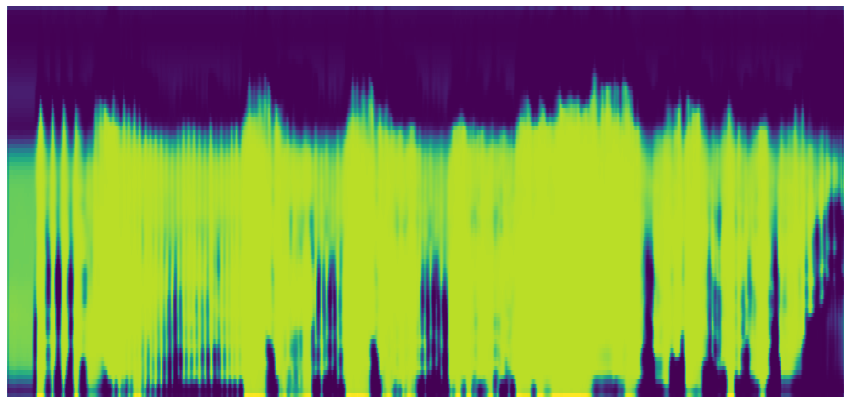

In [31]:
from note_creation import model_output_to_notes
np_mats = {
    'note': np.asarray(output[1]).reshape(-1, 88),
    'onset': np.asarray(output[2]).reshape(-1, 88),
    'contour': np.asarray(output[0]).reshape(-1, 264)
}

# print(np_mats['note'])

plot_mat(np_mats['note'].T)
pm_predicted, note_events = model_output_to_notes(np_mats, 0.15, 0.05, include_pitch_bends=True, min_note_len=1, melodia_trick=False)

predicted_audio = pm_predicted.synthesize(fs=22050)[:22050 * duration]
predicted = Audio(predicted_audio, rate=22050)
display(predicted)

### Basic Pitch predicted audio and MIDI
We know you probably don't have the compute available to train this model to useful results; however, we still want you to see and hear the capabilities of this model, so these are the outputs from the published version of the model.

Predicting MIDI for raw_audio_chopped.wav...


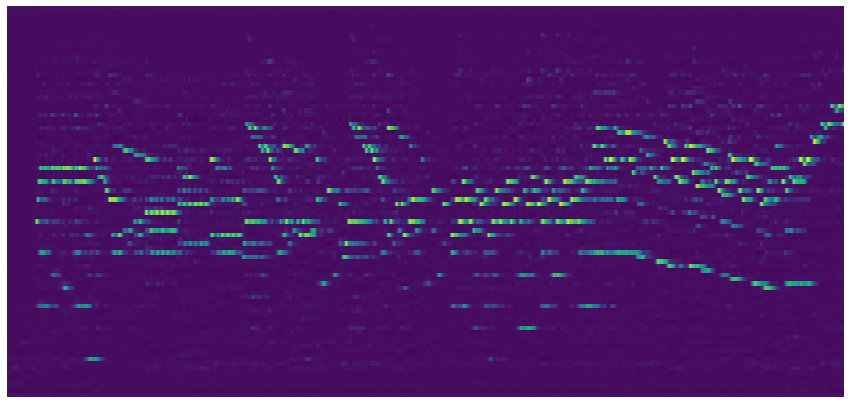

In [32]:
from scipy.io.wavfile import write

output_path = "raw_audio_chopped.wav"
write(output_path, rate=22050, data=raw_audio)

from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH

model_output, midi_data, note_activations = predict(output_path)

plot_mat(model_output['note'].T)

bp_audio = midi_data.synthesize(fs=22050)[:22050 * duration]
bp = Audio(bp_audio, rate=22050)
display(bp)

# HW Q4: Ablation Studies 

Now that we have successfully trained the model, we can probe how certain layers are necessary to the models' various outputs. 

The ablations we will test out include:
1. Removing the first convolutional layer, batch norm, and RELU block in the yp branch
2. Not concatenating the output of the note branch (yn_branch) and the top branch when producing the onset output. 


Solutions: Answers may vary depending on what particular parameters people use to train their model with, and for how many epochs it is trained for.
Ablation 1, projected affected impacts: Removing the first convolutional block is actually accidentally what the authors did! Their original code miscoded the passing of outputs through the various layers, and led to the inputs being convolved differently than intended. It’s therefore possible that the outputs students see may be more similar to what the published model generated; students may also see a worsened form of the outputs or a more noisy/less defined pitch and note posterior gram. 


Ablation 2, projected affected impacts: With no concatenation, the onsets that are generated will not be informed by the notes generated by the other branch, and will likely be misaligned with them as a result. 
